In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Reshape, Flatten, \
  LeakyReLU, Activation, Dropout, Concatenate, BatchNormalization, \
  ConvLSTM2D, ZeroPadding2D, Cropping2D, RepeatVector
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import metrics, losses

from sklearn.model_selection import train_test_split

import time

import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os
os.chdir("/content/drive/MyDrive/data_exchange/")

Mounted at /content/drive


In [ ]:
dataset = np.load('pv4.npy')[::50,]

In [ ]:
nx = dataset.shape[1]
ny = dataset.shape[2]

## pre-process data

In [ ]:
def norm_train(x,min_x,max_x):
  return 2*(x-min_x)/(max_x-min_x)-1
  #-1 1

def norm_out(x,min_x,max_x):
  return (x-min_x)/(max_x-min_x)
  #0 1

In [ ]:
# normalize data
dataset_x =norm_train(dataset,dataset.min(),dataset.max())
dataset_y =norm_out(dataset,dataset.min(),dataset.max())


# split train/val/test
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.15)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.05)

# setup Unet

In [ ]:
# define the encoder block
def convolution_block(layer_in, n_filters, kernel_size, stride, batchnorm=True):

  # weight initialization
	init = tf.random_normal_initializer(0., 0.02)

  # add downsampling layer
	g = Conv2D(n_filters, kernel_size=kernel_size, strides=stride, padding='same',
            kernel_initializer=init, use_bias=False)(layer_in)

  # conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g)#, training=True)
	# leaky relu activation
	g = LeakyReLU()(g)
	return g

# define the decoder block
def deconvolution_concat_block(layer_in, skip_in, n_filters, kernel_size, stride, cropping, dropout=True):

  # weight initialization
	init = tf.random_normal_initializer(0., 0.02)

  # add upsampling layer
	g = Conv2DTranspose(n_filters, kernel_size=kernel_size, strides=stride, padding='same',
                     kernel_initializer=init, use_bias=False)(layer_in)
	# add cropping
	g = Cropping2D(cropping=cropping)(g)

  # add batch normalization
	g = BatchNormalization()(g)#, training=True)

	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g)#, training=True)

  # relu activation
	g = Activation('relu')(g)

  # merge with skip connection
	g = Concatenate()([g, skip_in])
	#lm = ConvLSTM2D(256, (2,2), padding='same', return_sequences=True,
	#                dropout=0.2, recurrent_dropout=0.2)(skip_in, training=True)
	#g = Concatenate()([g, lm])

	return g

# define the decoder block
def deconvolution_block(layer_in, n_filters, kernel_size, stride, cropping, dropout=True):

  # weight initialization
	init = tf.random_normal_initializer(0., 0.02)

  # add upsampling layer
	g = Conv2DTranspose(n_filters, kernel_size=kernel_size, strides=stride, padding='same',
                     kernel_initializer=init, use_bias=False)(layer_in)
	# add cropping
	g = Cropping2D(cropping=cropping)(g)

  # add batch normalization
	g = BatchNormalization()(g)#, training=True)

  # relu activation
	g = Activation('relu')(g)

	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g)#, training=True)

	return g


In [ ]:

# define the standalone generator model
def define_generator(image_shape):

  # weight initialization
	init = tf.random_normal_initializer(0., 0.02)

  # image input
	in_image = Input(shape=image_shape)

  # encoder model:
	e1 = convolution_block(in_image, 16, (4,4), (2,2), batchnorm=False)
 	# e1 = Concatenate(axis=1)([e1, e1, e1, e1])

	e2 = convolution_block(e1, 32, (4,4), (2,2))
	#e3 = convolution_block(e2, 64, (4,4), (2,2))
	#e4 = convolution_block(e3, 128, (4,4), (2,2))
	#e5 = convolution_block(e4, 128, (4,4), (2,2))
	#e6 = convolution_block(e5, 256, (4,4), (2,2))
	b = convolution_block(e2, 64, (4,4), (1,1))

	# bottleneck LSTM
	#b = ConvLSTM2D(256, (2,2), padding='same', return_sequences=True,
	#               dropout=0.2, recurrent_dropout=0.2)(b, training=True)
	#b = ConvLSTM2D(256, (2,2), padding='same', return_sequences=True,
	#               dropout=0.2, recurrent_dropout=0.2)(b, training=True)

  # decoder model:
	#d1 = deconvolution_concat_block(b, e6, 256, (4,4), (1,1), ((0,0),(0,0)))
	#d2 = deconvolution_concat_block(d1, e5, 128, (4,4), (2,2), ((0,0),(0,0)))

	#d3 = deconvolution_concat_block(d2, e4, 128, (4,4), (2,2), ((0,0),(0,0)))
	#d4 = deconvolution_concat_block(d3, e3, 128, (4,4), (2,2), ((1,0),(1,0)))
	d5 = deconvolution_concat_block(b, e2, 64, (4,4), (1,1), ((0,0),(0,0)))
	d6 = deconvolution_concat_block(d5, e1, 16, (4,4), (2,2), ((0,0),(0,0)), dropout=False)
	d6 = deconvolution_block(d6, 16, (4,4), (1,1), ((0,0),(0,0)), dropout=False)
	d6 = deconvolution_block(d6, 16, (4,4), (1,1), ((0,0),(0,0)), dropout=False)

  # # output
	out_image = Conv2DTranspose(1, 4, strides=2, padding='same',
                     kernel_initializer=init)(d6)

	out_image = Activation('relu')(out_image)

  # define model
	model = Model(in_image, out_image)

	return model

def define_discriminator(in_shape, out_shape):

  # Weight initialization
  init = tf.random_normal_initializer(0., 0.02)

  inp_X = Input(shape=in_shape) # Input layer past data
  inp_Y = Input(shape=out_shape) # Input layer future data

  # Add some noise
  h1 = tf.keras.layers.GaussianNoise(0.01)(inp_X)
  h2 = tf.keras.layers.GaussianNoise(0.01)(inp_Y)

  # Bring data into same shape
  h1 = convolution_block(h1, 32, (4,4), (2,2), batchnorm=False)
  #h1 = convolution_block(h1, 64, (4,4), (2,2))
  #h1 = convolution_block(h1, 128, (4,4), (2,2))

  h2 = convolution_block(h2, 32, (4,4), (2,2), batchnorm=False)
  #h2 = convolution_block(h2, 64, (4,4), (2,2))
  #h2 = convolution_block(h2, 128, (4,4), (2,2))

  # Concatenate data
  h = Concatenate()([h1, h2])

  h = convolution_block(h, 256, (4,4), (2,2))
  # h = convolution_block(h, 256, (4,4,4), (1,2,2))
  # h = convolution_block(h, 256, (3,4,4), (1,2,2))

  # h = ZeroPadding2D()(h)
  h = Conv2D(256, (4,4), strides=(2,2), padding='same',
                                kernel_initializer=init,
                                use_bias=False)(h)
  h = BatchNormalization()(h)
  h = LeakyReLU()(h)

  # h = ZeroPadding3D()(h)
  outp = Conv2D(1, (4,4), strides=(1,1), padding='same',
                                kernel_initializer=init)(h)

  model = Model([inp_X, inp_Y], outp)

  return model


In [ ]:
input_shape=(nx,ny,1)
output_shape=(nx,ny,1)

generator=define_generator(input_shape)
generator.summary()
discriminator = define_discriminator(input_shape,output_shape)
discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 32, 32, 16)           256       ['input_4[0][0]']             
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 16)           0         ['conv2d_8[0][0]']            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 16, 16, 32)           8192      ['leaky_re_lu_7[0][0]']       
                                                                                            

## define losses and training step

In [ ]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # MAE
  l1_loss = tf.reduce_mean(tf.abs(target-gen_output))

  total_gen_loss = gan_loss + LAMBDA * l1_loss

  return total_gen_loss, gan_loss, l1_loss

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.math.scalar_mul(0.9, tf.ones_like(disc_real_output)), disc_real_output)

  generated_loss = loss_object(tf.math.add(0.1, tf.zeros_like(disc_generated_output)), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(input_image, target, epoch):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  return gen_total_loss, disc_loss

def fit(data_in,data_out, epoch):
    for i in range(epoch):

        now = time.time()

        step = tf.constant(1)

        inds=np.arange(len(data_in))
        np.random.shuffle(inds)
        for ind in inds:
            gen_total_loss, disc_loss = train_step(data_in[None,ind,:,:,:].astype(np.float32), data_out[None,ind,:,:,:].astype(np.float32), step)
            step += tf.constant(1)

                #print(step)

        later = time.time()
        print('time for epoch: '+str(i)+' took '+str(int(later - now)) + ' sec')
        print(gen_total_loss)
        print(disc_loss)


# train unet

In [ ]:
fit(x_train,y_train,10)

time for epoch: 0 took 28 sec
time for epoch: 1 took 14 sec
time for epoch: 2 took 13 sec
time for epoch: 3 took 13 sec
time for epoch: 4 took 13 sec
time for epoch: 5 took 14 sec
time for epoch: 6 took 15 sec
time for epoch: 7 took 15 sec
time for epoch: 8 took 15 sec
time for epoch: 9 took 15 sec


# Evaluation

In [ ]:
def rmse(a,b):
  return np.sqrt(np.mean((a-b)**2))

In [ ]:
rec_val_data = generator(x_val)
print(rmse(rec_val_data,y_val))

rec_test_data = generator(x_test)
print(rmse(rec_test_data,y_test))

0.012547139
0.013352598


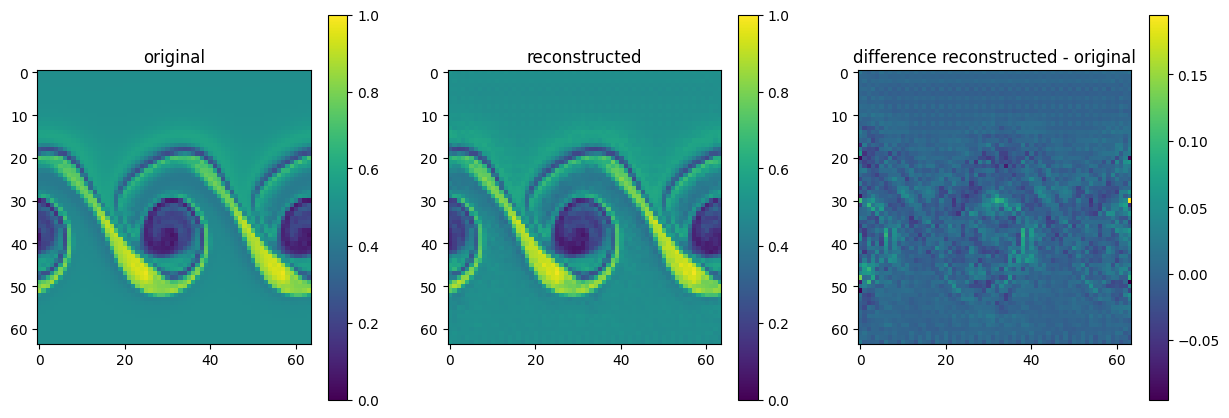

In [ ]:
iid=1

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(y_test[iid,:,:,0], vmin=0, vmax=1)
plt.title('original')
plt.colorbar()

plt.subplot(132)
plt.imshow(rec_test_data[iid,:,:,0], vmin=0, vmax=1)
plt.title('reconstructed')
plt.colorbar()

plt.subplot(133)
plt.imshow(rec_test_data[iid,:,:,0]-y_test[iid,:,:,0]) #, cmap = 'seismic'
plt.title('difference reconstructed - original')
plt.colorbar()


In [ ]:
dataset_noise=x_test+np.random.uniform(-0.3,0.3,x_test.shape)

# normalize data
dataset_x_noise =norm_train(dataset_noise,dataset_noise.min(),dataset_noise.max())
dataset_y_noise =norm_out(dataset_noise,dataset_noise.min(),dataset_noise.max())

rec_test_data_noise = generator(dataset_x_noise)
print(rmse(rec_test_data_noise, dataset_y_noise))

0.03504119


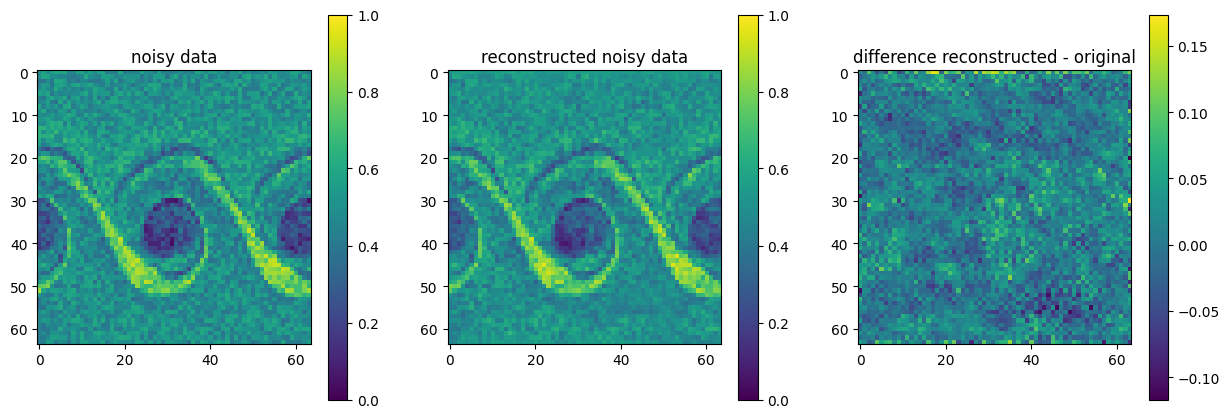

In [ ]:
# iid=4
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(dataset_y_noise[iid,:,:,0], vmin=0, vmax=1)
plt.title('noisy data')
plt.colorbar()

plt.subplot(132)
plt.imshow(rec_test_data_noise[iid,:,:,0], vmin=0, vmax=1)
plt.title('reconstructed noisy data')
plt.colorbar()

plt.subplot(133)

plt.imshow(rec_test_data_noise[iid,:,:,0]-dataset_y_noise[iid,:,:,0]) #, cmap = 'seismic'
plt.title('difference reconstructed - original')

plt.colorbar()
